## Image segmentation with fastai

In [27]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

In [28]:
path = os.getcwd()
img_path = path+'/data/h5'
path_img = img_path+'/sem_seg'
path_lbl = path+'/data/h5/merged_masks'

## Data

In [29]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/georg/fyp/data/h5/sem_seg/9142800_5819600.png'),
 WindowsPath('C:/Users/georg/fyp/data/h5/sem_seg/9142800_5820000.png'),
 WindowsPath('C:/Users/georg/fyp/data/h5/sem_seg/9143200_5814800.png')]

In [30]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/georg/fyp/data/h5/merged_masks/9142800_5819600_mask.tif'),
 WindowsPath('C:/Users/georg/fyp/data/h5/merged_masks/9142800_5820000_mask.tif'),
 WindowsPath('C:/Users/georg/fyp/data/h5/merged_masks/9143200_5814800_mask.tif')]

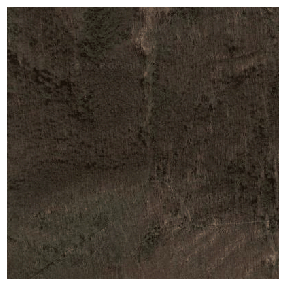

In [31]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [32]:
get_y_fn = lambda x: path_lbl+f'/{x.stem}_mask.tif'

In [33]:
lbl_names[1]

WindowsPath('C:/Users/georg/fyp/data/h5/merged_masks/9142800_5820000_mask.tif')

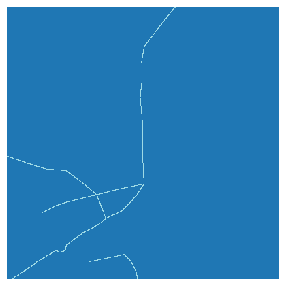

In [34]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [35]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([400, 400]),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [36]:
mask.size

torch.Size([400, 400])

In [37]:
codes = array(['Background' , 'Building', 'Highway', 'Rail'])

In [38]:
codes

array(['Background', 'Building', 'Highway', 'Rail'], dtype='<U10')

In [39]:
mask.data.sum()

tensor(2408)

## Datasets

In [40]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 3777MB of GPU RAM free


In [41]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [42]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [65]:
data.valid_dl = data.valid_dl.new(shuffle=True)

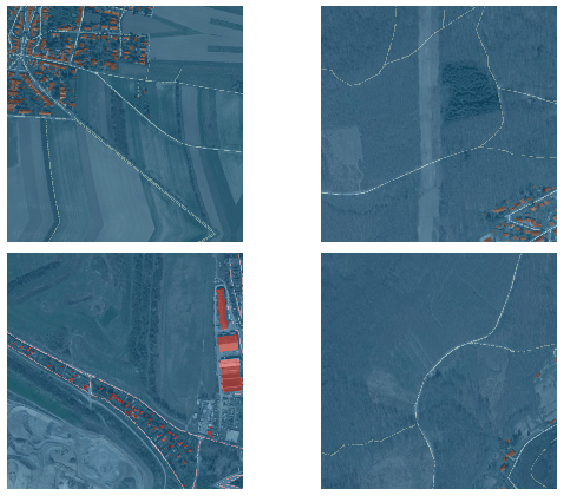

In [43]:
data.show_batch(2, figsize=(10,7))

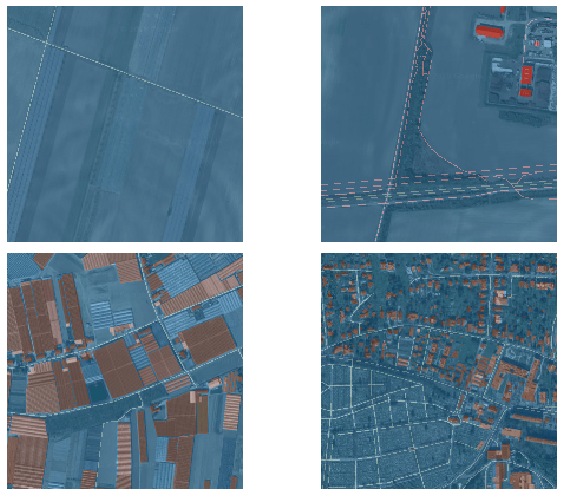

In [44]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [45]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [46]:
metrics=acc_camvid

In [47]:
wd=1e-2

In [48]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


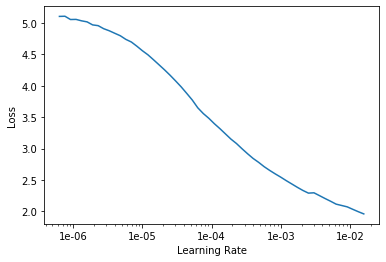

In [49]:
lr_find(learn)
learn.recorder.plot()

In [50]:
lr=3e-3

In [51]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.455116,0.397528,0.317220,03:27
1,0.402752,0.373236,0.446456,03:34
2,0.393544,0.351404,0.346614,03:38
3,0.370248,0.346213,0.458679,03:30
4,0.375713,0.342937,0.409023,03:18
5,0.351632,0.329136,0.450116,03:17
6,0.380484,0.320132,0.453936,03:19
7,0.350475,0.313460,0.500071,03:16
8,0.356952,0.326097,0.440119,03:16
9,0.323277,0.301901,0.520729,03:16


In [52]:
learn.save('stage-1')

In [74]:
learn.load('stage-1');

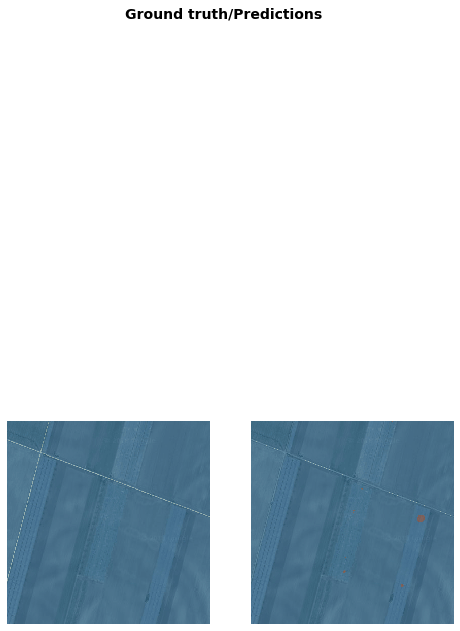

In [75]:
learn.show_results(rows=3, figsize=(8,15))

In [76]:
learn.unfreeze()

In [77]:
lrs = slice(lr/400,lr/4)

In [78]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.352042,0.313760,nan,11:50


KeyboardInterrupt: 

In [ ]:
learn.show_results(rows=3, figsize=(10,18))

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [69]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 3643MB of GPU RAM free


In [70]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [71]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [72]:
learn.load('stage-2');

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\georg\\fyp\\data\\h5\\sem_seg\\models\\stage-2.pth'

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [43]:
learn.save('stage-1-big')

In [44]:
learn.load('stage-1-big');

In [45]:
learn.unfreeze()

In [46]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.151572,0.162342,0.623651,02:05
1,0.147360,0.162101,0.628433,02:05
2,0.156635,0.159409,0.622148,02:05
3,0.147783,0.159225,0.618545,02:05


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin